# Monte Carlo Integration with Acceptance-Rejection
Zhiqiang Tan, 2006, JCGS: http://stat.rutgers.edu/home/ztan/Publication/armcSept06.pdf

## 1. Intro
**Goal:**
- Estimate expectation of arbitrary function $f$ with respect to $p$:
$A=\mathbb{E}_{x \sim p}[f(x)]$
    - Special case: estimate $\mathcal{Z} = \mathbb{E}_{x \sim p}[x]$

**Notation:**
- $q:\mathcal{X}\to \mathbb{R}^+$
$$p(x) = \mathcal{Z}^{-1} q(x)$$
w.r.t. baseline measure $\mu_0$
where
    - $x \in \mathcal{X}$
    - $\mathcal{Z} \equiv \int q(x) d\mu_0$

**Setting:**
- Sequence of variates has been simulated from $p(\cdot)$ by rejection sampling or Metropolis-Hastings: $$x_1,\dots,x_n \sim p$$ 

**Crude Monte Carlo (CMC) estimator:**
$$\hat{C}_\text{CMC} = \frac{1}{n} \sum_{i=1}^n f(x_i)$$

**Reciprocal importance sampling (RIS) estimator:**
- CMC when $f:x \mapsto q_1(x)/q(x)$ leads to:
$$\hat{\mathcal{Z}}_\text{RIS} = \left( \frac{1}{n} \sum_{i=1}^n \frac{q_1(x_i)}{q(x_i)}\right)^{-1}$$

**Rejection sampling:**
- Given: probability density $\rho(x)$ and $C\in \mathbb{R}^+$ such that $q(x) \leq C \rho (x) \forall x \in \mathcal{X}$:
    - Sample $y_t \sim \rho$
    - Accept $y_t$ with probability $C^{-1} q(y_t)/\rho(y_t)$

**Metropolis-Hastings:**
- Given: family of probability densities $\{ \rho (\cdot | x) : x \in \mathcal{X} \}$:
    - Sample $y_t \sim \rho(\cdot | x_{t-1})$
    - Sample $u_t \sim \text{Unif}[0,1]$.
        - If $u_t \leq \alpha(y,x)$,
            - let $x_t\leftarrow y_t$
        - Else, 
            - $x_t \leftarrow x_{t-1}$
    
    where
    $$ \alpha(y,x) \equiv \frac{q(y) \rho (x | y) }{q(x) \rho (y | x) }$$

**Observation:**
- In both algorithms, acceptance/rejection depends on uniform random variables. By integrating out these uniform random variables, it is possible to reduce variance.

**Likelihood approach:**
- Pose Monte Carlo integration as model-based inference: given Monte Carlo samples (data), infer baseline measure (parameter)

## 2. Rejection sampling

## 3. Metropolis-Hastings

$$\tilde{Z} \equiv \int q(y) d \tilde{\mu} = \sum_{i=1}^n \frac{q(y_i)}{\sum_{j=1}^n \rho (y_i | x_{j-1})}$$

In [1]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
from scipy.stats import multivariate_normal as mvn

In [65]:
dist = mvn(mean=np.zeros(10),cov=1.0)

In [148]:
# target density
def blob(x):
    return (np.exp(-np.sum(x**2)) + np.exp(-np.sum((x-2)**2)))*0.1*np.sum(np.sin(10*x)**2)


# random-walk metropolis hastings with gaussian proposals
def rw_mh(f, x, callback=None, num_iters=1000, sigma=1.0):
    xs = [x]
    old_f = f(x)
    acceptance_rate = 0
    
    dist = mvn(mean=np.zeros(len(x)),cov=sigma**2)

    for i in range(num_iters):
        proposal = xs[-1]+dist.rvs()
        if callback!=None:
            callback(xs,old_f)
        new_f = f(proposal)
        
        if new_f/old_f >= npr.rand():
            # accept
            old_f = new_f
            xs.append(proposal)
            acceptance_rate += 1
        else:
            xs.append(xs[-1])
    print(1.0*acceptance_rate/len(xs))
    return np.array(xs)

In [142]:
delta = 0.05
x = np.arange(-2.0, 4.0, delta)
y = np.arange(-2.0, 4.0, delta)
X, Y = np.meshgrid(x, y)


Z = np.zeros(X.shape)
for i in range(len(Z)):
    for j in range(len(Z.T)):
        Z[i,j] = blob(np.array([X[i,j],Y[i,j]]))

In [185]:
sigma=0.5
xs = rw_mh(blob,np.ones(2),num_iters=5000,sigma=sigma)

0.565086982603


In [186]:
xs.shape

(5001, 2)

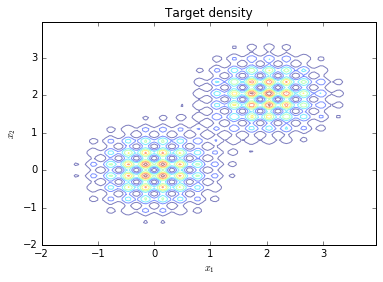

In [187]:
plt.contour(X,Y,Z,
            #levels=np.logspace(-10,3,30),
            #cmap='Blues',
            alpha=0.5,antialiased=True)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Target density')

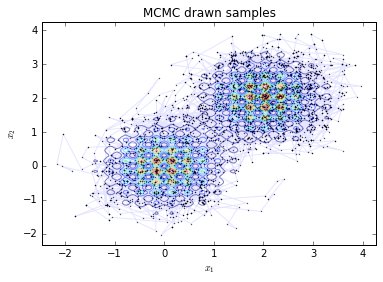

In [188]:
plt.contour(X,Y,Z,
            #levels=np.logspace(-10,3,30),
            #cmap='Blues',
            alpha=0.5,antialiased=True)
x,y = xs[:,0],xs[:,1]
plt.scatter(x,y,s=0.1,c='black')
plt.plot(x,y,alpha=0.1)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('MCMC drawn samples')

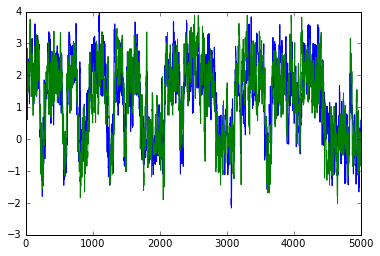

In [189]:
plt.plot(x)
plt.plot(y)

In [190]:
from scipy.spatial.distance import pdist,squareform
distances = squareform(pdist(xs))

In [191]:
rho = np.exp(-distances**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

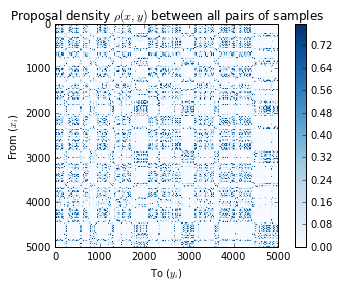

In [192]:
plt.imshow(rho,interpolation='none',cmap='Blues')
plt.xlabel(r'To ($y_i$)')
plt.ylabel(r'From ($x_i$)')

plt.colorbar()
plt.title(r'Proposal density $\rho(x,y)$ between all pairs of samples')

In [193]:
def compute_Z_hat_(q,xs,rho):
    '''
    Implementing in slow / non-vectorized form first for ease of reading / checking.
    
    Parameters
    ----------
    
    q: callable
    
    xs: (N,d), numpy.ndarray of samples
    
    rho: (N,N), numpy.ndarray of reals
    '''
    Z_hat = 0
    n = len(xs)
    for i in range(n):
        numerator = q(xs[i])
        denominator = 0
        
        for j in range(n):
            denominator += rho[i,j]
        Z_hat += numerator / denominator
    return Z_hat

In [194]:
def compute_Z_hat(q,xs,rho):
    '''
    Vectorized!
    
    Parameters
    ----------
    
    q: callable
    
    xs: (N,d), numpy.ndarray of samples
    
    rho: (N,N), numpy.ndarray of reals
    '''
    return sum(np.array([q(x) for x in xs]) / rho.sum(0))

In [195]:
%%time
Z_hat = compute_Z_hat_(blob,xs,rho)

CPU times: user 5.4 s, sys: 295 ms, total: 5.7 s
Wall time: 5.71 s


In [196]:
%%time
Z_hat_vectorized = compute_Z_hat(blob,xs,rho)

CPU times: user 104 ms, sys: 13.6 ms, total: 117 ms
Wall time: 106 ms


In [197]:
print(Z_hat,Z_hat_vectorized)

(0.7047341659014621, 0.7047341659014621)


In [198]:
assert(Z_hat==Z_hat_vectorized)

In [199]:
np.dtype('float64')

dtype('float64')

In [200]:
def harmonic_mean_estimator(q,xs):
    qs = np.array([q(x) for x in xs],dtype=np.dtype('float64'))
    return 1.0/(np.mean(1.0/qs))

hme = harmonic_mean_estimator(blob,xs)
hme

0.023267811278570125

In [204]:
qs = np.array([blob(x) for x in xs],dtype=np.dtype('float64'))
sum(qs==0),sum(qs<0)

In [ ]:
# get a ground-truth value

In [201]:
from scipy.integrate import dblquad

In [202]:
Z_true = dblquad(lambda x,y:blob(np.array([x,y])),-4,6,lambda x:-4,lambda x:6)

In [203]:
Z_true

(0.6283185216120079, 5.203036511347618e-10)

(0, 0)

# A theory of statistical models for Monte Carlo integration


# On a likelihood approach to Monte Carlo Integration
Zhiqiang Tan, 2004, JASA, http://stat.rutgers.edu/home/ztan/Publication/likmcDec04.pdf

# Monte Carlo integration with Markov Chain